# Milestone #3 - CS109A

Andreas Rousing and Evan DeFilippis, 11/28/2018

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat
from IPython.display import display

from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import exposure
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2grey

import os
import re

# Load Training and Test Data

In [2]:
# Load pre-constructed train/test arrays from Stanford Dataset
train_list = loadmat('./lists/train_list.mat')
test_list = loadmat('./lists/test_list.mat')

In [3]:
# Split training data into a directory list, label list, and annotation list
file_list_train = [i.item() for i in train_list["file_list"].flatten()]
label_list_train = [i.item() for i in train_list["labels"].flatten()]
annotation_list_train = [i.item() for i in train_list['annotation_list'].flatten()]

# Split testing data into a directory list, label list, and annotation list
file_list_test = [i.item() for i in test_list["file_list"].flatten()]
label_list_test = [i.item() for i in test_list["labels"].flatten()]
annotation_list_test = [i.item() for i in test_list['annotation_list'].flatten()]

In [4]:
# Examine contents of lists
print(file_list_train[0], "|", label_list_train[0], "|", annotation_list_train[0])

n02085620-Chihuahua/n02085620_5927.jpg | 1 | n02085620-Chihuahua/n02085620_5927


In [5]:
# Build a function to extract the breed name from the file list
def extract_breed(file_string):
    return re.search(r'\-(.*?)\/',file_string).group(1)

# Function to extract the breed name and clean string
def clean_breed(file_string):    
    breed = re.search(r'\-(.*?)\/',file_string).group(1)
    breed = breed.replace("_", " ")
    breed = breed.title()
    
    return(breed)

In [6]:
# Build DataFrames containing directory structure, name of breed, and label
breed_list_train = [clean_breed(i) for i in file_list_train]
breed_list_test = [clean_breed(i) for i in file_list_test]

train_df = pd.DataFrame(
    list(zip(file_list_train, annotation_list_train, \
    breed_list_train, label_list_train)), \
    columns=['File', 'Annotation', 'Breed', 'Label'])

test_df = pd.DataFrame(
    list(zip(file_list_test, annotation_list_test, \
    breed_list_test, label_list_test)), \
    columns=['File', 'Annotation', 'Breed', 'Label'])

In [7]:
# View the training dataframe
train_df.head()

File  \
0   n02085620-Chihuahua/n02085620_5927.jpg   
1   n02085620-Chihuahua/n02085620_4441.jpg   
2   n02085620-Chihuahua/n02085620_1502.jpg   
3   n02085620-Chihuahua/n02085620_1916.jpg   
4  n02085620-Chihuahua/n02085620_13151.jpg   

                            Annotation      Breed  Label  
0   n02085620-Chihuahua/n02085620_5927  Chihuahua      1  
1   n02085620-Chihuahua/n02085620_4441  Chihuahua      1  
2   n02085620-Chihuahua/n02085620_1502  Chihuahua      1  
3   n02085620-Chihuahua/n02085620_1916  Chihuahua      1  
4  n02085620-Chihuahua/n02085620_13151  Chihuahua      1

In [8]:
# View test dataframe
test_df.head()

File                          Annotation  \
0  n02085620-Chihuahua/n02085620_2650.jpg  n02085620-Chihuahua/n02085620_2650   
1  n02085620-Chihuahua/n02085620_4919.jpg  n02085620-Chihuahua/n02085620_4919   
2  n02085620-Chihuahua/n02085620_1765.jpg  n02085620-Chihuahua/n02085620_1765   
3  n02085620-Chihuahua/n02085620_3006.jpg  n02085620-Chihuahua/n02085620_3006   
4  n02085620-Chihuahua/n02085620_1492.jpg  n02085620-Chihuahua/n02085620_1492   

       Breed  Label  
0  Chihuahua      1  
1  Chihuahua      1  
2  Chihuahua      1  
3  Chihuahua      1  
4  Chihuahua      1

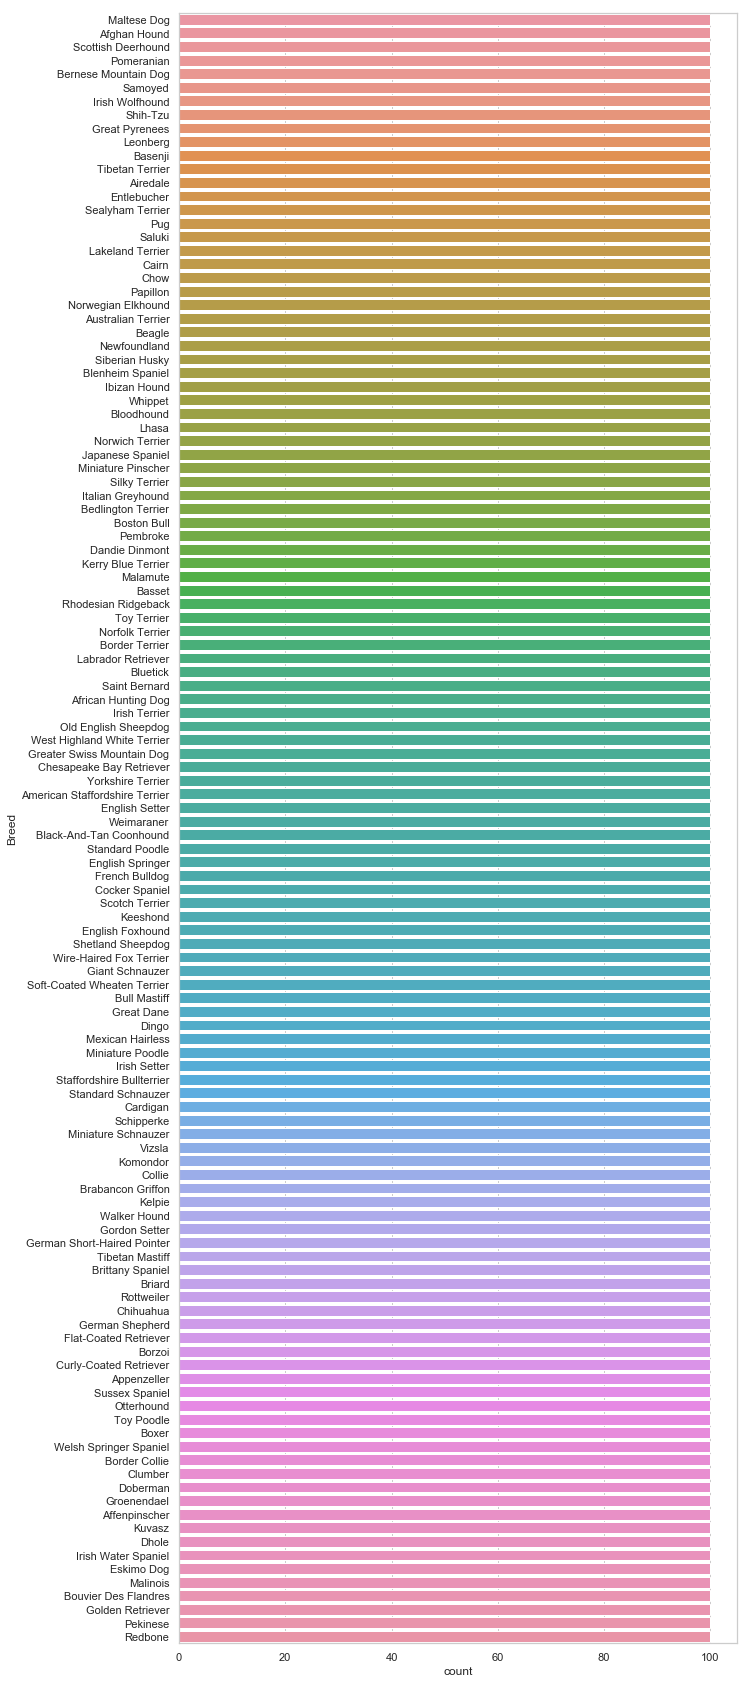

In [9]:
# Plot the breakdown of breeds in the training set
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 30))
ax = sns.countplot(y="Breed", data=train_df,
                   order = test_df['Breed'].value_counts().index)

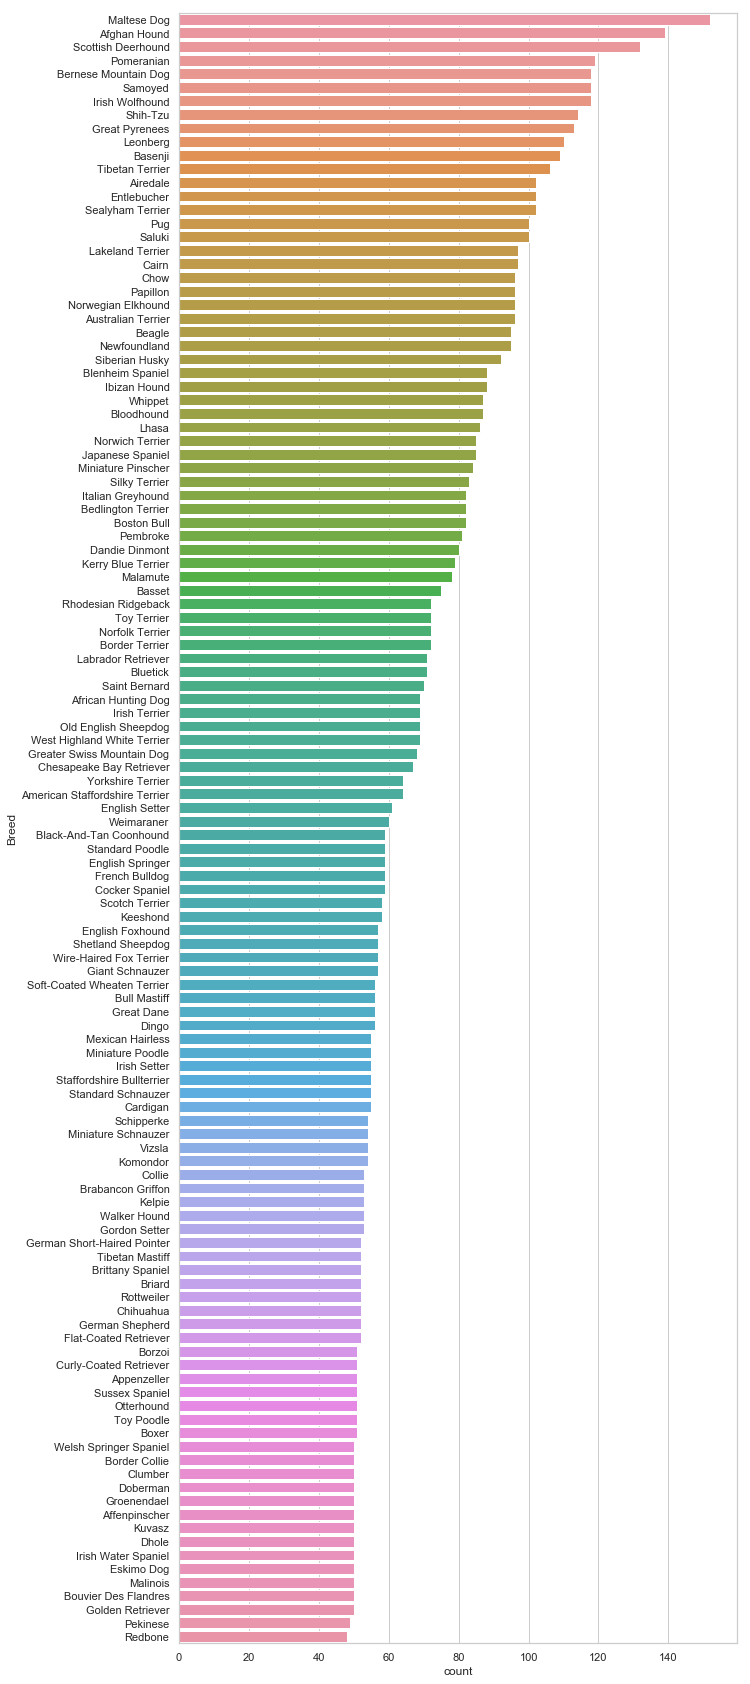

In [10]:
#Plot the breakdown of breeds in the test set
fig, ax = plt.subplots(figsize=(10, 30))
ax = sns.countplot(y="Breed", data=test_df, 
                   order = test_df['Breed'].value_counts().index)

In [11]:
# Generates a bounding box of the image of the dog from the Annotations list
def generate_bounding_box(file_string):
    file = open(file_string, 'r', encoding="utf-8")
    file_content=file.readlines() 

    x_min = float(re.search(r'<xmin>(.+?)</xmin>', file_content[18]).group(1))
    y_min = float(re.search(r'<ymin>(.+?)</ymin>', file_content[19]).group(1))
    x_max = float(re.search(r'<xmax>(.+?)</xmax>', file_content[20]).group(1))
    y_max = float(re.search(r'<ymax>(.+?)</ymax>', file_content[21]).group(1))  
    
    box_height = y_max - y_min  
    box_width = x_max - x_min
          
    bounding_box = [x_min, y_min, box_width, box_height]

    return(bounding_box)     

# Visualize First 20 Dog Breeds in Training Set

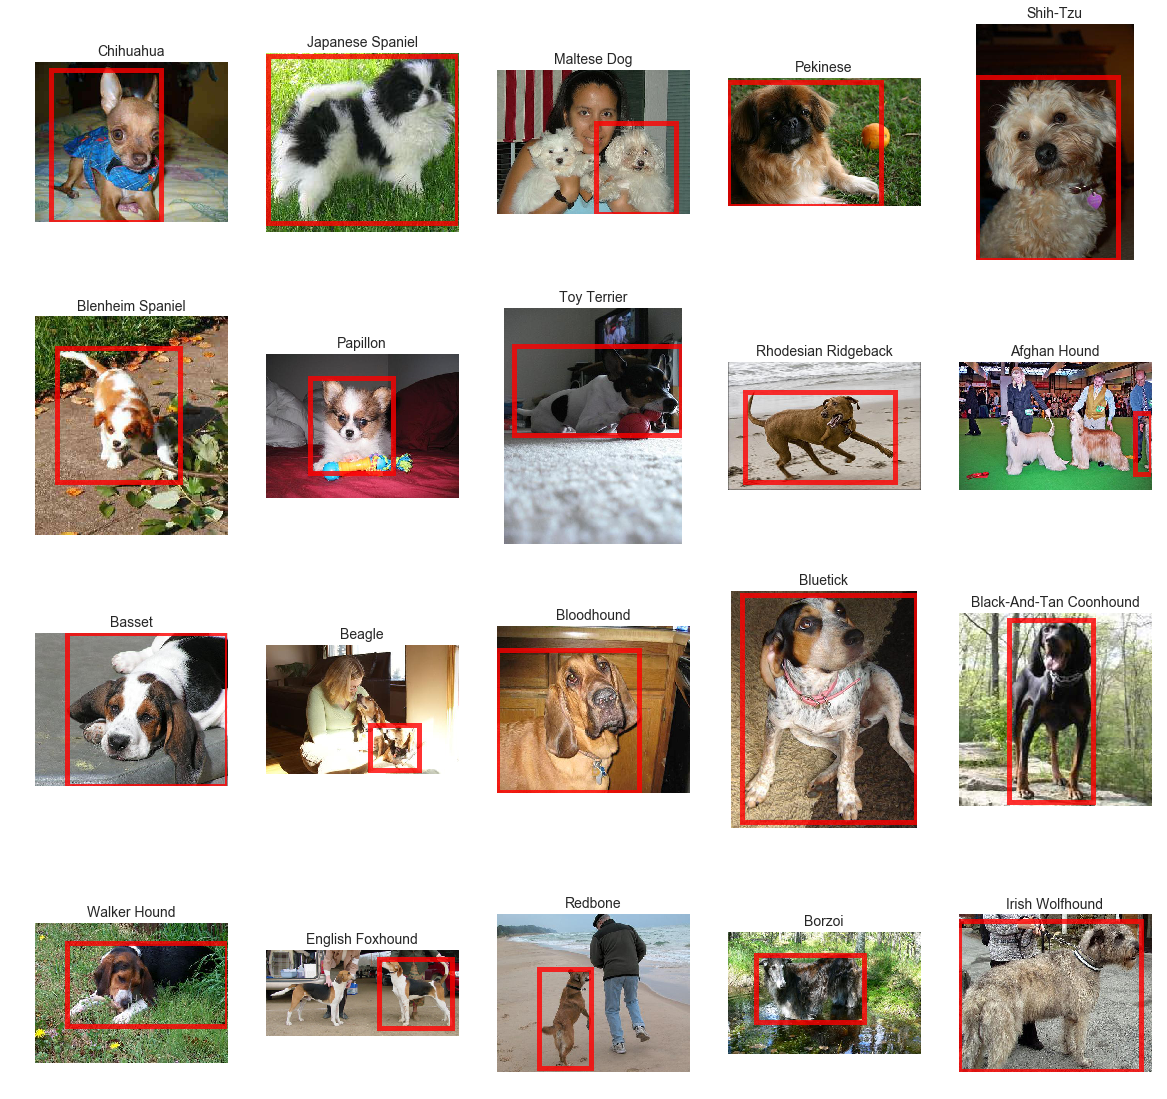

In [12]:
# Generates a randomly shuffled dataframe
# with one copy of each breed for plotting purposes
train_df_plot = train_df.sample(frac=1, random_state = 42)
train_df_plot = train_df.drop_duplicates(subset="Breed")

# Creates a 4x5 plotting environment
fig, axes = plt.subplots(4,5, figsize=(20,20))
ax = axes.flatten()
counter = 0

# Have to reduce images to the first 20 due to IOPub Rate Limiting
for index, breed in train_df_plot[0:20].iterrows():
    image_data = plt.imread("Images/" + breed['File'])
    ax[counter].imshow(image_data)
    
    # Generates a bounding box around the dog
    x, y, w, h = generate_bounding_box("Annotation/" \
                    + train_df['Annotation'][index])
    rect = patches.Rectangle((x,y), w ,h ,
                             linewidth=5,
                             edgecolor='Red',
                             facecolor='None',
                             fill = False,
                             alpha = .8)

    # Add the patch to the Axes
    ax[counter].add_patch(rect)

    # Set Title
    ax[counter].set_title(breed['Breed'], fontsize=14)
    ax[counter].set_axis_off()
    counter += 1

# Visualize First 20 Dog Breeds in Test Set

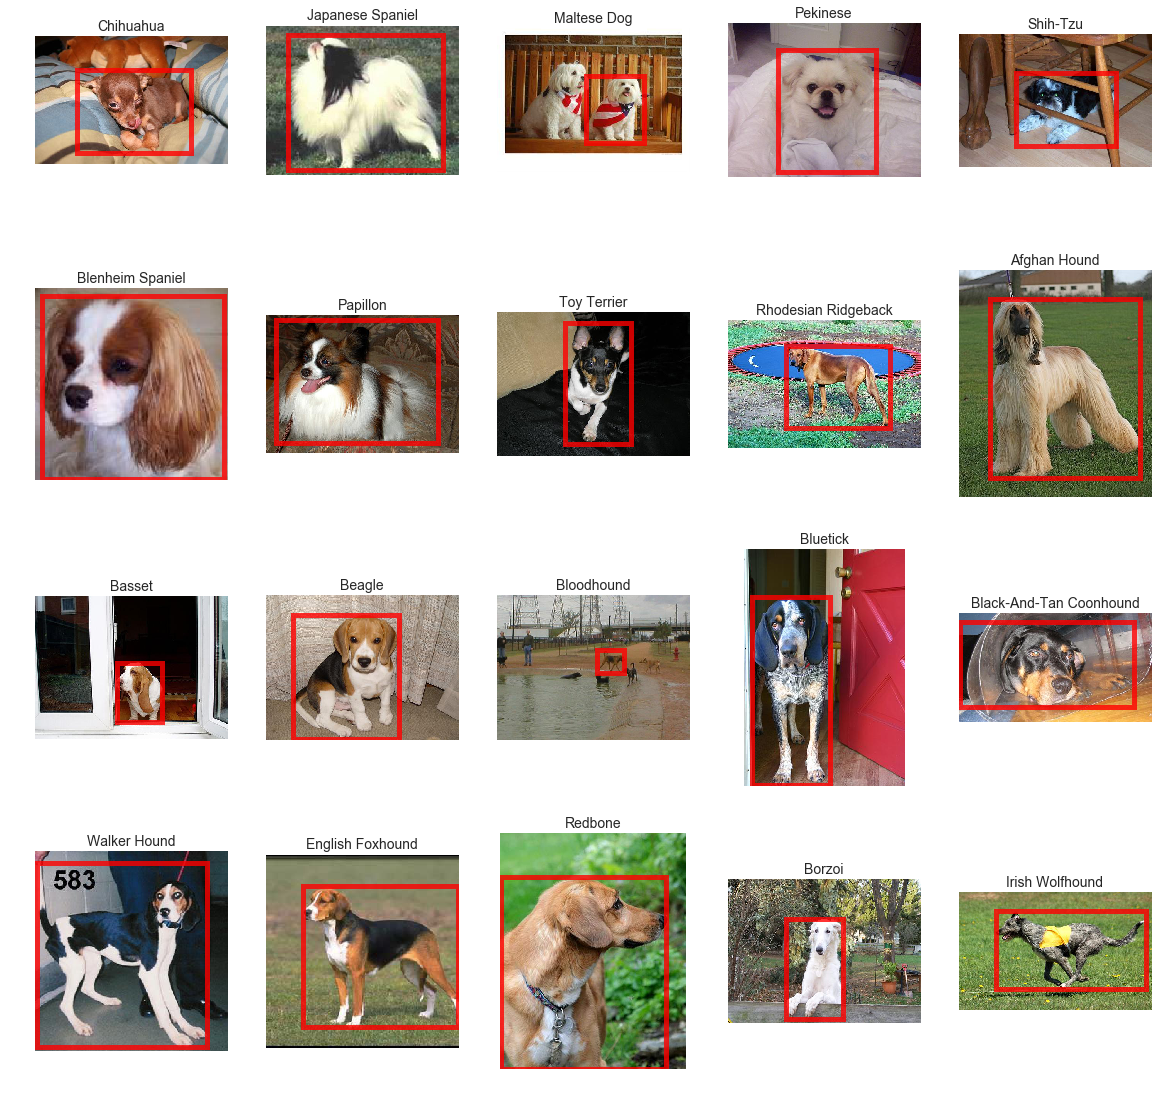

In [13]:
# Generates a randomly shuffled dataframe
# with one copy of each breed for plotting purposes
test_df_plot = test_df.sample(frac=1, random_state = 42)
test_df_plot = test_df.drop_duplicates(subset="Breed")

# Creates a 4x5 plotting environment
fig, axes = plt.subplots(4,5, figsize=(20,20))
ax = axes.flatten()
counter = 0

# Have to reduce images to the first 20 due to IOPub Rate Limiting
for index, breed in test_df_plot[0:20].iterrows():
    image_data = imread("Images/" + breed['File'])
    ax[counter].imshow(image_data)
    
    # Generates a bounding box around the dog
    x, y, w, h = generate_bounding_box("Annotation/" \
                    + test_df['Annotation'][index])
    rect = patches.Rectangle((x,y), w ,h ,
                             linewidth=5,
                             edgecolor='Red',
                             facecolor='None',
                             fill = False,
                             alpha = .8)

    # Add the patch to the Axes
    ax[counter].add_patch(rect)

    # Set Title
    ax[counter].set_title(breed['Breed'], fontsize=14)
    ax[counter].set_axis_off()
    counter += 1

# Generate Sample Images with Filters

In [14]:
# Inspiration from this Repo
# #https://github.com/kcirtap2014/stanford_dog_breed

from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.exposure import rescale_intensity
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2grey

import random

# Define a helper functions
# http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_adapt_rgb.html
@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

# Random image indices we want to visualize
image_indices = random.sample(range(1, train_df.shape[0]), 5)

# Generate empty list of lists to store transformed images
images = [[] for i in range(len(image_indices))]
grey_scale_transform = [[] for i in range(len(image_indices))]
sobel_transform = [[] for i in range(len(image_indices))]
exposure_equalize_transform = [[] for i in range(len(image_indices))]


# Iterate over all images and apply an illustrative transform
for i, key in enumerate(image_indices):
    images[i] = imread("images/" + train_df.loc[key].File);
    
    # Process into grey scale for illustrative purposes
    grey_scale_transform[i] = rgb2grey(images[i])
    
    # Sobel's edge detection algorithm 
    sobel_transform[i] = rescale_intensity(1 - sobel_each(images[i]))
    
    # Equalization
    exposure_equalize_transform[i] = exposure.equalize_hist(image[i])

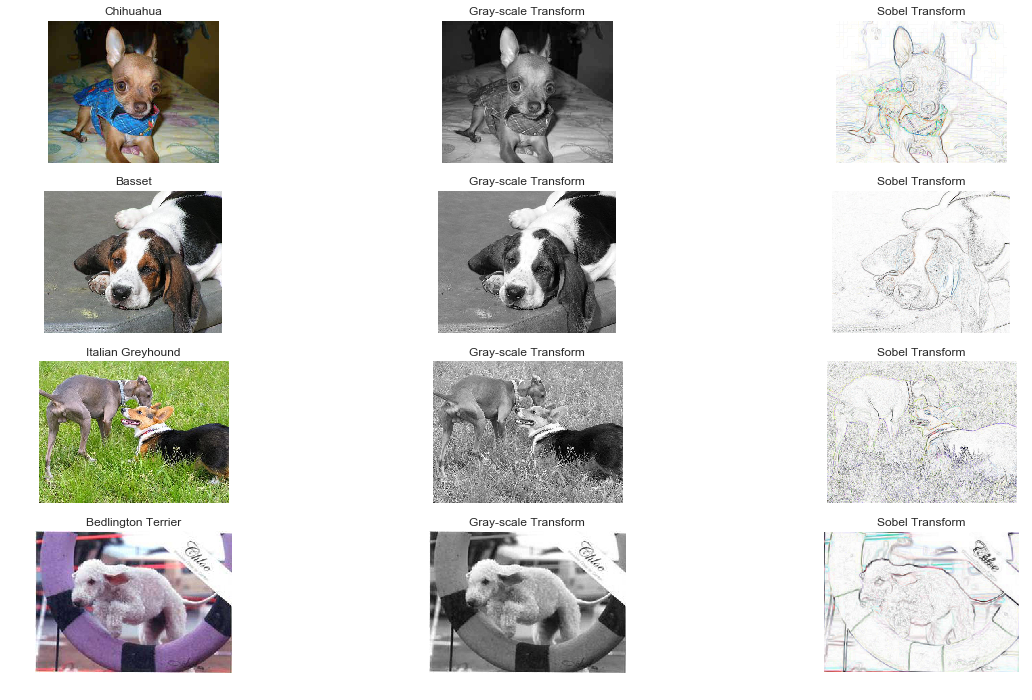

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
counter = 0

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')

    if i % 3 == 0:
        ax.imshow(images[counter])
        ax.set_title(train_df.loc[image_indices[counter]].Breed)
    elif i % 3 == 1:
        ax.imshow(grey_scale_transform[counter], cmap=plt.cm.gray)
        ax.set_title("Gray-scale Transform")
    elif i % 3 == 2:
        ax.imshow(sobel_transform[counter])
        ax.set_title('Sobel Transform')
        counter += 1